<a href="https://colab.research.google.com/github/Pradeep24032004/Data-Science-Assignment-eCommerce-Transactions-Dataset/blob/main/Maggala_Pradeep_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")
customers

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15
...,...,...,...,...
195,C0196,Laura Watts,Europe,2022-06-07
196,C0197,Christina Harvey,Europe,2023-03-21
197,C0198,Rebecca Ray,Europe,2022-02-27
198,C0199,Andrea Jenkins,Europe,2022-12-03


In [3]:
# Preprocessing Customers dataset
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
customers['SignupYear'] = customers['SignupDate'].dt.year

In [4]:
# Encode the 'Region' column
label_encoder = LabelEncoder()
customers['RegionEncoded'] = label_encoder.fit_transform(customers['Region'])

In [5]:
# Aggregate transaction data
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
transactions['Year'] = transactions['TransactionDate'].dt.year

In [6]:
# Create customer transaction summary
txn_summary = transactions.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'Quantity': 'sum',
    'TotalValue': 'sum',
    'ProductID': 'nunique'
}).rename(columns={
    'TransactionID': 'TransactionCount',
    'ProductID': 'UniqueProducts'
}).reset_index()


In [7]:
# Merge datasets
customer_data = pd.merge(customers, txn_summary, on='CustomerID', how='left')
customer_data.fillna(0, inplace=True)

In [8]:
# Feature engineering
features = ['SignupYear', 'RegionEncoded', 'TransactionCount', 'Quantity', 'TotalValue', 'UniqueProducts']
X = customer_data[features]
X


,SignupYear,RegionEncoded,TransactionCount,Quantity,TotalValue,UniqueProducts
0,2022,3,5.0,12.0,3354.52,5.0
1,2022,0,4.0,10.0,1862.74,4.0
2,2024,3,4.0,14.0,2725.38,4.0
3,2022,3,8.0,23.0,5354.88,8.0
4,2022,0,3.0,7.0,2034.24,3.0
...,...,...,...,...,...,...
195,2022,1,4.0,12.0,4982.88,3.0
196,2023,1,3.0,9.0,1928.65,3.0
197,2022,1,2.0,3.0,931.83,2.0
198,2022,1,4.0,9.0,1979.28,4.0


In [9]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


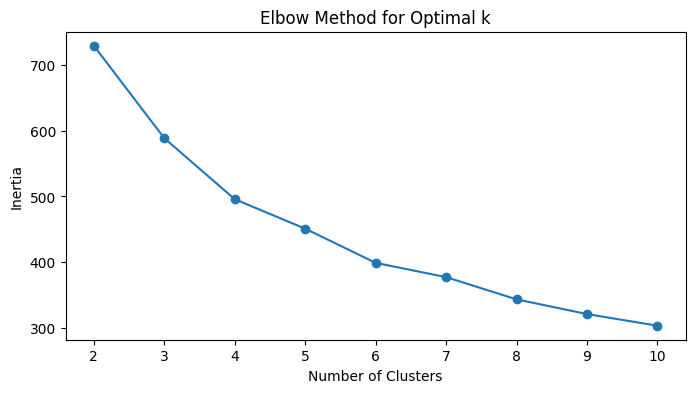

In [10]:
# Determine optimal number of clusters using the Elbow method
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Perform clustering with the chosen number of clusters (e.g., 4)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)
customer_data['Cluster'] = kmeans.labels_

In [11]:
# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(X_scaled, customer_data['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 1.2724364961055743


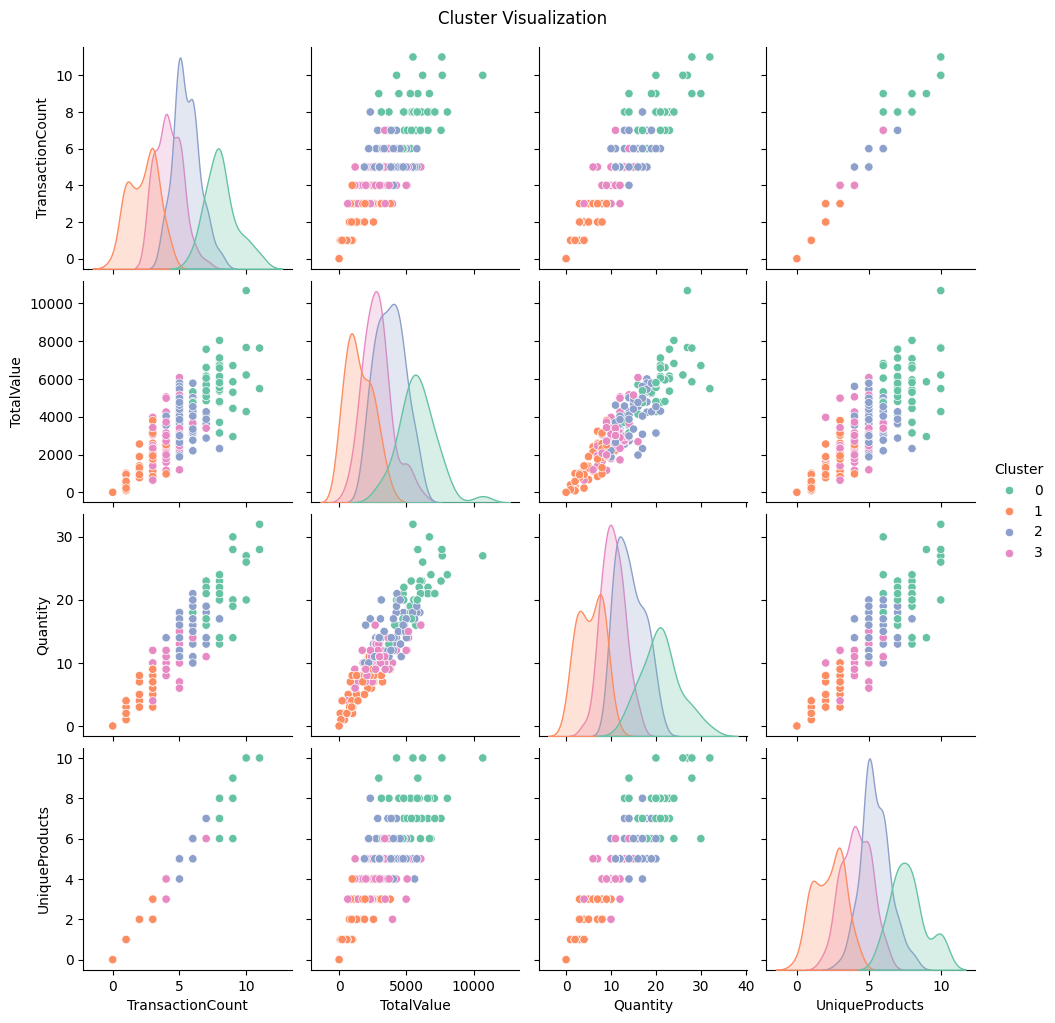

In [12]:
# Visualize clusters
sns.pairplot(customer_data, hue='Cluster', vars=['TransactionCount', 'TotalValue', 'Quantity', 'UniqueProducts'], palette='Set2')
plt.suptitle('Cluster Visualization', y=1.02)
plt.show()

In [13]:

# Save the clustered data
customer_data.to_csv("Clustered_Customers.csv", index=False)